In [12]:
#import das biblíotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')


In [13]:
# Carregar o dataset

df = pd.read_csv("station_data_dataverse.csv")


In [14]:
#Comando para visualizar os dados

df.head()


,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
0,1366563,7.78,0.00,0014-11-18 15:40:26,0014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,3,0,1,0,0,0,0,0,0
1,3075723,9.74,0.00,0014-11-19 17:40:26,0014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,3,0,0,1,0,0,0,0,0
2,4228788,6.76,0.58,0014-11-21 12:05:46,0014-11-21 16:46:04,12,16,4.671667,Fri,android,...,0,3,0,0,0,0,1,0,0,0
3,3173284,6.17,0.00,0014-12-03 19:16:12,0014-12-03 21:02:18,19,21,1.768333,Wed,android,...,0,3,0,0,1,0,0,0,0,0
4,3266500,0.93,0.00,0014-12-11 20:56:11,0014-12-11 21:14:06,20,21,0.298611,Thu,android,...,0,3,0,0,0,1,0,0,0,0


In [15]:
# Limpeza de dados, para remover valores nulos ou de colunas categóricas

df.dropna(inplace=True)
df = pd.get_dummies(df, drop_first=True)


In [16]:
# Criação de uma coluna de 'demanda futura'

df['future_demand'] = df['kwhTotal'].shift(-1)


In [17]:
#Remoção das linhas com valores nulos gerados pelo shift

df.dropna(inplace=True)


In [18]:
# Separar as features (X) e o alvo (y)

X = df.drop('future_demand', axis=1).select_dtypes(include=[np.number])
y = df['future_demand']


In [19]:
# Divisão em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Treinamento do modelo

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [21]:
# Avaliação do modelo

y_pred = model_rf.predict(X_test)
print("Erro Quadrático Médio (MSE):", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE):", mean_absolute_error(y_test, y_pred))

Erro Quadrático Médio (MSE): 2.8943553169313305
Erro Absoluto Médio (MAE): 1.1967834763948497


In [22]:
# Reshape para LSTM

X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))


In [23]:
# Construção do modelo LSTM

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
history = model_lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test))


Epoch 1/20
59/59 [==============================] - 1s 7ms/step - loss: 125564108800.0000 - val_loss: 88206032896.0000
Epoch 2/20
59/59 [==============================] - 0s 4ms/step - loss: 632822824960.0000 - val_loss: 43874328576.0000
Epoch 3/20
59/59 [==============================] - 0s 4ms/step - loss: 149990440960.0000 - val_loss: 3346592256.0000
Epoch 4/20
59/59 [==============================] - 0s 4ms/step - loss: 34385604608.0000 - val_loss: 115847102464.0000
Epoch 5/20
59/59 [==============================] - 0s 4ms/step - loss: 40906924032.0000 - val_loss: 2191283456.0000
Epoch 6/20
59/59 [==============================] - 0s 4ms/step - loss: 14319282176.0000 - val_loss: 2692232704.0000
Epoch 7/20
59/59 [==============================] - 0s 4ms/step - loss: 4486363136.0000 - val_loss: 1588282880.0000
Epoch 8/20
59/59 [==============================] - 0s 5ms/step - loss: 2950488576.0000 - val_loss: 55883360.0000
Epoch 9/20
59/59 [==============================] - 0s 4ms/st

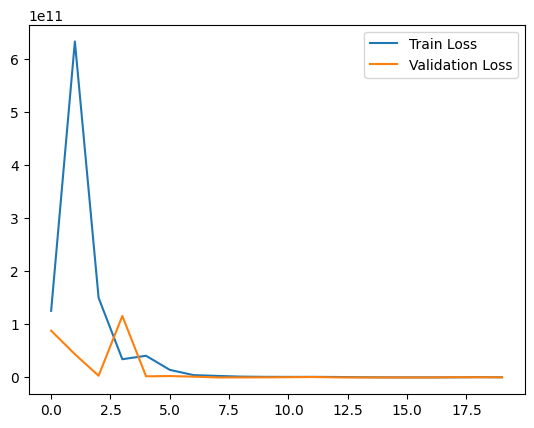

In [25]:
# Visualização da perda durante o treinamento

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [26]:
# Predições

y_pred_rf = model_rf.predict(X_test)
y_pred_lstm = model_lstm.predict(X_test_lstm)


15/15 [==============================] - 0s 2ms/step


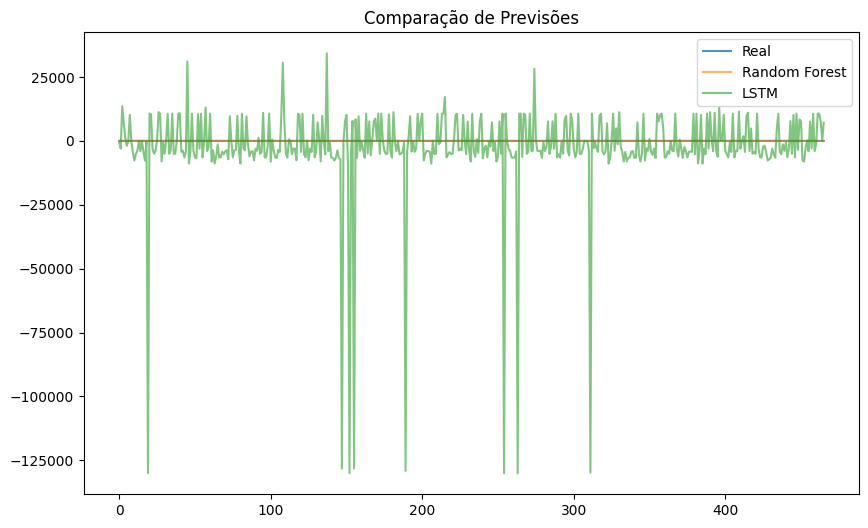

In [27]:
# Comparação entre valores reais e preditos

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Real', alpha=0.8)
plt.plot(y_pred_rf, label='Random Forest', alpha=0.6)
plt.plot(y_pred_lstm, label='LSTM', alpha=0.6)
plt.legend()
plt.title("Comparação de Previsões")
plt.show()
